# WASP-80b: Broadband data preparation 

## Overview

The broadband analysis uses three broadband datasets by Triaud et al. (T13, 2013), Fukui et al. (F14, 2014), and Mancini et al. (M14, 2014), containing 27 light curves observed in g', r', i', z', I, J, H, K. The T13 and M14 datasets contain only the time, flux, and flux uncertainty estimates, while the F14 dataset contains also a set of useful covariates, such as the airmass and FWHM estimates.

We start the broadband analysis by homogenising the three datasets into a common format, and store the data in a HDF5-file `DDATA/external_lcs.h5`. The F14 data is stored as Pandas DataFrames, and the T13, and M14 light curves as Pandas Series. The structure of the file is

    /lc/fukui2014/H/irsf_130716             frame        (shape->[537,7]) 
    /lc/fukui2014/H/irsf_130822             frame        (shape->[576,7]) 
    /lc/fukui2014/H/irsf_131007             frame        (shape->[597,7]) 
    /lc/fukui2014/J/irsf_130716             frame        (shape->[541,7]) 
    /lc/fukui2014/J/irsf_130822             frame        (shape->[566,7]) 
    /lc/fukui2014/J/irsf_131007             frame        (shape->[597,7]) 
    /lc/fukui2014/J/isle_130813             frame        (shape->[324,7]) 
    /lc/fukui2014/J/isle_130922             frame        (shape->[241,7]) 
    /lc/fukui2014/K/irsf_130716             frame        (shape->[539,7]) 
    /lc/fukui2014/K/irsf_130822             frame        (shape->[582,7]) 
    /lc/fukui2014/K/irsf_131007             frame        (shape->[603,7]) 
    /lc/fukui2014/g/oao50_130813            frame        (shape->[562,7]) 
    /lc/fukui2014/g/oao50_130922            frame        (shape->[268,7]) 
    /lc/fukui2014/i/oao50_130813            frame        (shape->[563,7]) 
    /lc/fukui2014/i/oao50_130922            frame        (shape->[295,7]) 
    /lc/fukui2014/r/oao50_130813            frame        (shape->[566,7]) 
    /lc/fukui2014/r/oao50_130922            frame        (shape->[290,7]) 
    /lc/mancini2014/H/grond                 series       (shape->[508])   
    /lc/mancini2014/J/grond                 series       (shape->[508])   
    /lc/mancini2014/K/grond                 series       (shape->[508])   
    /lc/mancini2014/g/grond                 series       (shape->[162])   
    /lc/mancini2014/i/dfosc                 series       (shape->[156])   
    /lc/mancini2014/i/grond                 series       (shape->[156])   
    /lc/mancini2014/r/grond                 series       (shape->[156])   
    /lc/mancini2014/z/grond                 series       (shape->[157])   
    /lc/triaud2013/r/eulercam_1             series       (shape->[208])   
    /lc/triaud2013/z/trappist_1             series       (shape->[721])   
    /lc/triaud2013/z/trappist_2             series       (shape->[704])   
    /transmission                           frame        (shape->[2151,7])
    
**Note:** We also store the transmission as a function of wavelength for each passband in the HDF5-file, under `/transmission`, and simplify the analysis a bit by merging the i' and I bands: the average transmission is used for both passbands.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as pf
import pandas as pd
import seaborn as sb
from glob import glob
from os.path import basename, splitext, join
from astropy.table import Table

sys.path.append(join('..','..'))

from exotk.utils.misc import fold
from src.extcore import TC, P, TZERO, DDATA

## Fukui et al. 2013

In [3]:
fnames = sorted(glob(join(DDATA,'fukui_2014/[i,o]*dat')))
hnames = list(map(lambda s: 'lc/fukui2014/{t[1]:s}/{t[0]:s}_{t[2]:s}'.format(t=splitext(basename(s))[0].split('-')), fnames))
hnames = list(map(lambda s: s.replace('/I/','/i/').replace('/G/','/g/').replace('/R/','/r/'), hnames))

In [4]:
dfs = {}
for fname,hname in zip(fnames,hnames):
    df = pd.read_csv(fname, sep=' ')
    df = pd.DataFrame(df.values[:,:-2], columns=df.columns[1:-1])
    stime = pd.Series(df.iloc[:,0].values + 2450000, name='bjd', dtype=np.float64)
    df = pd.DataFrame(df.values[:,1:], index=stime, columns=df.columns[1:], dtype=np.float64)
    ph = fold(df.index.values, P, TC+TZERO, normalize=True, shift=0.5) - 0.5
    df['oe_mask'] = abs(ph) < 0.015
    df.flux = df.flux / median(df.flux[~df.oe_mask])
    df.to_hdf(join(DDATA,'external_lcs.h5'), hname)
    dfs[hname] = df

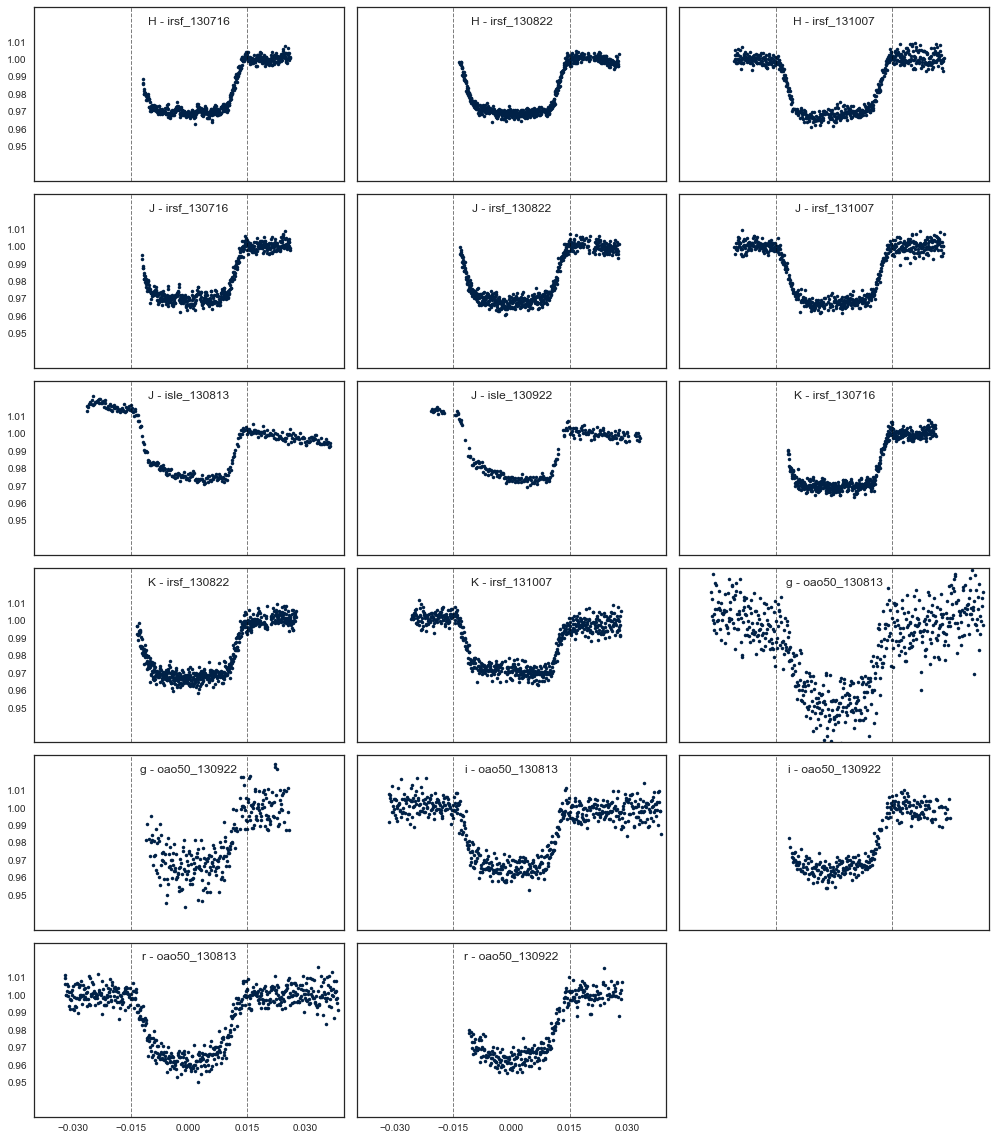

In [5]:
fig,axs = subplots(6,3,figsize=(14,16), sharey=True, sharex=True)
for k,ax in zip(sorted(dfs.keys()),axs.flat):
    df = dfs[k]
    ph = fold(df.index.values, P, TC+TZERO, normalize=True, shift=0.5) - 0.5
    fl = df.flux.values
    ax.plot(ph, fl, '.')
    ax.text(0.5,0.9,k.split('2014/')[1].replace('/',' - '), ha='center', transform=ax.transAxes)
    [ax.axvline(v, ls='--', c='k', lw=1, alpha=0.5) for v in [-0.015,0.015]]
setp(axs, ylim=(0.93,1.03), xlim=(-0.04,0.04), xticks=linspace(-0.03,0.03,5), yticks=linspace(0.95,1.01,7))
fig.tight_layout()
axs.flat[-1].set_visible(False)

## Triaud et al. 2013

Here we prepare the TRAPPIST and EulerCam light curves by Triaud et al. (2013) (Obtained from Vizier, http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/551/A80&-to=3)

The data contains two TRAPPIST z' light curves and an Euler r' light curve.

In [6]:
df = Table.read(join(DDATA,'triaud_2013_trappist.fits')).to_pandas()
df.columns = map(str.lower, df.columns)

In [7]:
mz1 = df.bjd < 6070
mr1 = (df.bjd < 6150) & (~mz1)
mz2 = (~mz1) & (~mr1)
df.bjd += 2450000

In [8]:
fz1 = pd.Series(df[mz1].flux.values, index=df[mz1].bjd.values, name='z_trappist_1')
fz2 = pd.Series(df[mz2].flux.values, index=df[mz2].bjd.values, name='z_trappist_2')
fr1 = pd.Series(df[mr1].flux.values, index=df[mr1].bjd.values, name='r_eulercam_')

In [9]:
with pd.HDFStore(join(DDATA,'external_lcs.h5')) as f:
    f.put('lc/triaud2013/z/trappist_1', fz1)
    f.put('lc/triaud2013/z/trappist_2', fz2)
    f.put('lc/triaud2013/r/eulercam_1', fr1)

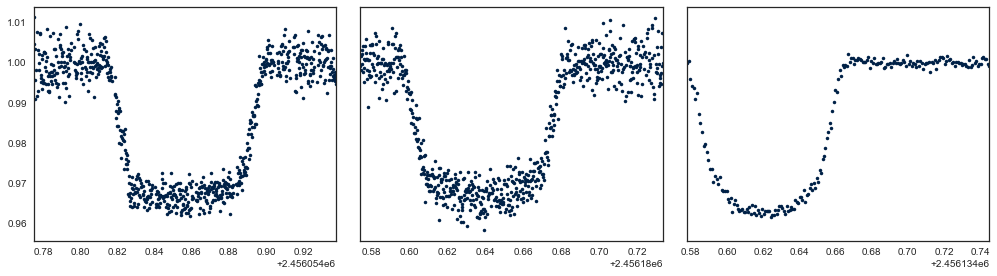

In [10]:
fig, axs = subplots(1,3,figsize=(14,4), sharey=True)
fz1.plot(ax=axs[0], style='.')
fz2.plot(ax=axs[1], style='.')
fr1.plot(ax=axs[2], style='.')
fig.tight_layout()

## Mancini et al. 2014

Mancini et al. Observe a single transit simultaneously with the Danish Telescope (Bessel I) and GROND (g r i z J H K).

In [11]:
DFOSC = ['I']
GROND = 'g r i z J H K'.split()

In [12]:
dfm = Table.read(join(DDATA, 'mancini_2014.fits')).to_pandas()
dfm.columns = map(str.lower, dfm.columns)
dfm.bjd += 2400000
dfm['flux'] = 10**(-dfm.mag/2.5)
dfm.drop(['mag','e_mag'], inplace=True, axis=1)
dfm.sort_values(['band','bjd'], inplace=True)

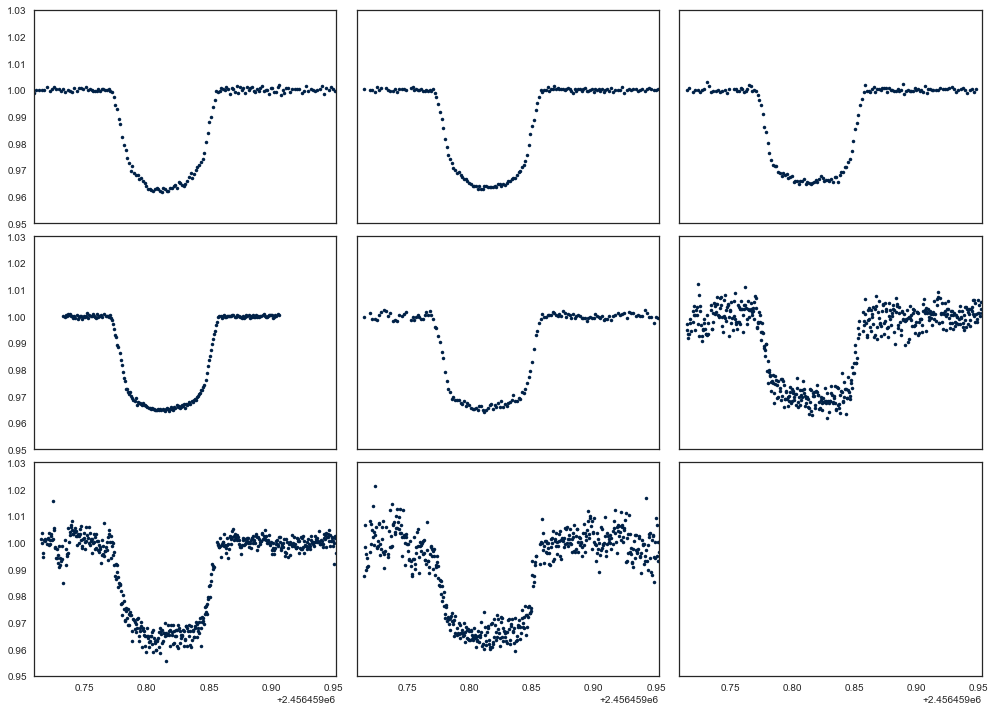

In [13]:
fig,axs = subplots(3,3, figsize=(14,10), sharey=True, sharex=True)
for i,band in enumerate('g r i I z J H K'.split()):
    dft = dfm[dfm.band==band]
    axs.flat[i].plot(dft.bjd, dft.flux, '.')
setp(axs, xlim=[dfm.bjd.min(),dfm.bjd.max()], ylim=(0.95, 1.03))
fig.tight_layout()

In [14]:
with pd.HDFStore(join(DDATA, 'external_lcs.h5'), 'a') as f:
    for band in dfm.band.unique():
        inst = 'grond' if band in GROND else 'dfosc'
        band = band.replace('I','i')
        name = 'lc/mancini2014/{band:s}/{name:s}'.format(band=band,name=inst)
        dft = dfm[dfm.band==band]
        f.put(name, pd.Series(dft.flux.values, dft.bjd.values, name=name))

## Save the transmission information 

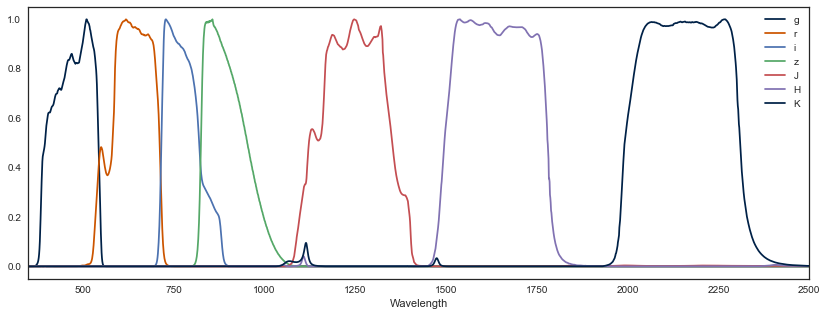

In [15]:
def N(a):
    return a/a.max()

def favg(filters):
    return N(sum(list(map(N, filters)), 0))

dff = pd.read_csv(join(DDATA, 'fukui_2014', 'TM_all.dat'), sep=' ')
dff = pd.DataFrame(dff.values[:,1:-1], columns=dff.columns[2:], index=pd.Series(dff.values[:,0], name='Wavelength'))
dfg = pd.read_csv(join(DDATA, 'GROND_filters.txt'), sep='\t', index_col=0)
dfg.index.name = 'Wavelength'

filter_names = 'g r i z J H K'.split()

transmission = array([favg([dfg.gBand, dff.MITSuME_g]),
                    favg([dfg.rBand, dff.MITSuME_Rc]),
                    favg([dfg.iBand, dff.MITSuME_Ic]),
                    N(dfg.zBand),
                    favg([dfg.JBand, dff['2MASS_J'], dff.IRSF_J]),
                    favg([dfg.HBand, dff.IRSF_H]),
                    favg([dfg.KBand, dff.IRSF_Ks])]).T

ddf = pd.DataFrame(data=transmission, columns=filter_names, index=dfg.index)
ddf.to_hdf(join(DDATA, 'external_lcs.h5'), 'transmission')
ddf.plot();

In [16]:
with pd.HDFStore(join(DDATA, 'external_lcs.h5')) as f:
    print(f)

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/hannu/Dropbox/Work/Projects/RoPACS/other/iac_collaboration/WASP_80b/data/external_lcs.h5
/lc/fukui2014/H/irsf_130716             frame        (shape->[537,7]) 
/lc/fukui2014/H/irsf_130822             frame        (shape->[576,7]) 
/lc/fukui2014/H/irsf_131007             frame        (shape->[597,7]) 
/lc/fukui2014/J/irsf_130716             frame        (shape->[541,7]) 
/lc/fukui2014/J/irsf_130822             frame        (shape->[566,7]) 
/lc/fukui2014/J/irsf_131007             frame        (shape->[597,7]) 
/lc/fukui2014/J/isle_130813             frame        (shape->[324,7]) 
/lc/fukui2014/J/isle_130922             frame        (shape->[241,7]) 
/lc/fukui2014/K/irsf_130716             frame        (shape->[539,7]) 
/lc/fukui2014/K/irsf_130822             frame        (shape->[582,7]) 
/lc/fukui2014/K/irsf_131007             frame        (shape->[603,7]) 
/lc/fukui2014/g/oao50_130813            frame        (shape->[562,7]) 
/lc

---

<center> &copy; 2017 <a href="mailto:hannu@iac.es">Hannu Parviainen</a></center>